Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=1998, batch_size=64, num_workers=4, in_memory=True, model_name='resnet101', do_scratch=False, num_epochs=10, n_train_stop=32768, n_val_stop=4096, lr=0.003, delta1=0.03, delta2=0.0, weight_decay=0.01, label_smoothing=0.0001, shuffle=True, verbose=True)

In [2]:
fovea.all_model_names

['resnet18', 'resnet50', 'resnet101']

# testing different networks

In [3]:
args = fovea.Params()
from retinoto_py import all_model_names

json_filename = args.data_cache / '13_model_comparison.json'

# %rm {json_filename}  # FORCING RECOMPUTE

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for do_mask in [True, False]:
        # for dataset in ['full']:# <HACK until bbox is finished> fovea.all_datasets:
        for dataset in fovea.all_datasets:
            args = fovea.Params(do_mask=do_mask)
            VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
            val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=args.n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            for model_name in fovea.all_model_names:
                args.model_name = model_name
                model = fovea.load_model(args)
                param_stats = fovea.count_parameters(model)
                total_layers = fovea.count_layers(model)
                tic = fovea.time.time()
                accuracy = fovea.get_validation_accuracy(args, model, val_loader, f"Model {args.model_name}\t dataset: {dataset}\t(do_mask={do_mask})")            
                toc = fovea.time.time()
                this_result = { 'model_name': model_name,
                                'do_mask': do_mask,
                                'dataset': dataset,
                                'accuracy': accuracy,
                                'wall_clock_time': toc-tic,
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
                all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)


Putting images in memory:   0%|          | 0/4096 [00:00<?, ?it/s]

Model resnet18	 dataset: full	(do_mask=True):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet50	 dataset: full	(do_mask=True):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet101	 dataset: full	(do_mask=True):   0%|          | 0/64 [00:00<?, ?it/s]

Putting images in memory:   0%|          | 0/4096 [00:00<?, ?it/s]

Model resnet18	 dataset: bbox	(do_mask=True):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet50	 dataset: bbox	(do_mask=True):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet101	 dataset: bbox	(do_mask=True):   0%|          | 0/64 [00:00<?, ?it/s]

Putting images in memory:   0%|          | 0/4096 [00:00<?, ?it/s]

Model resnet18	 dataset: full	(do_mask=False):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet50	 dataset: full	(do_mask=False):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet101	 dataset: full	(do_mask=False):   0%|          | 0/64 [00:00<?, ?it/s]

Putting images in memory:   0%|          | 0/4096 [00:00<?, ?it/s]

Model resnet18	 dataset: bbox	(do_mask=False):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet50	 dataset: bbox	(do_mask=False):   0%|          | 0/64 [00:00<?, ?it/s]

Model resnet101	 dataset: bbox	(do_mask=False):   0%|          | 0/64 [00:00<?, ?it/s]

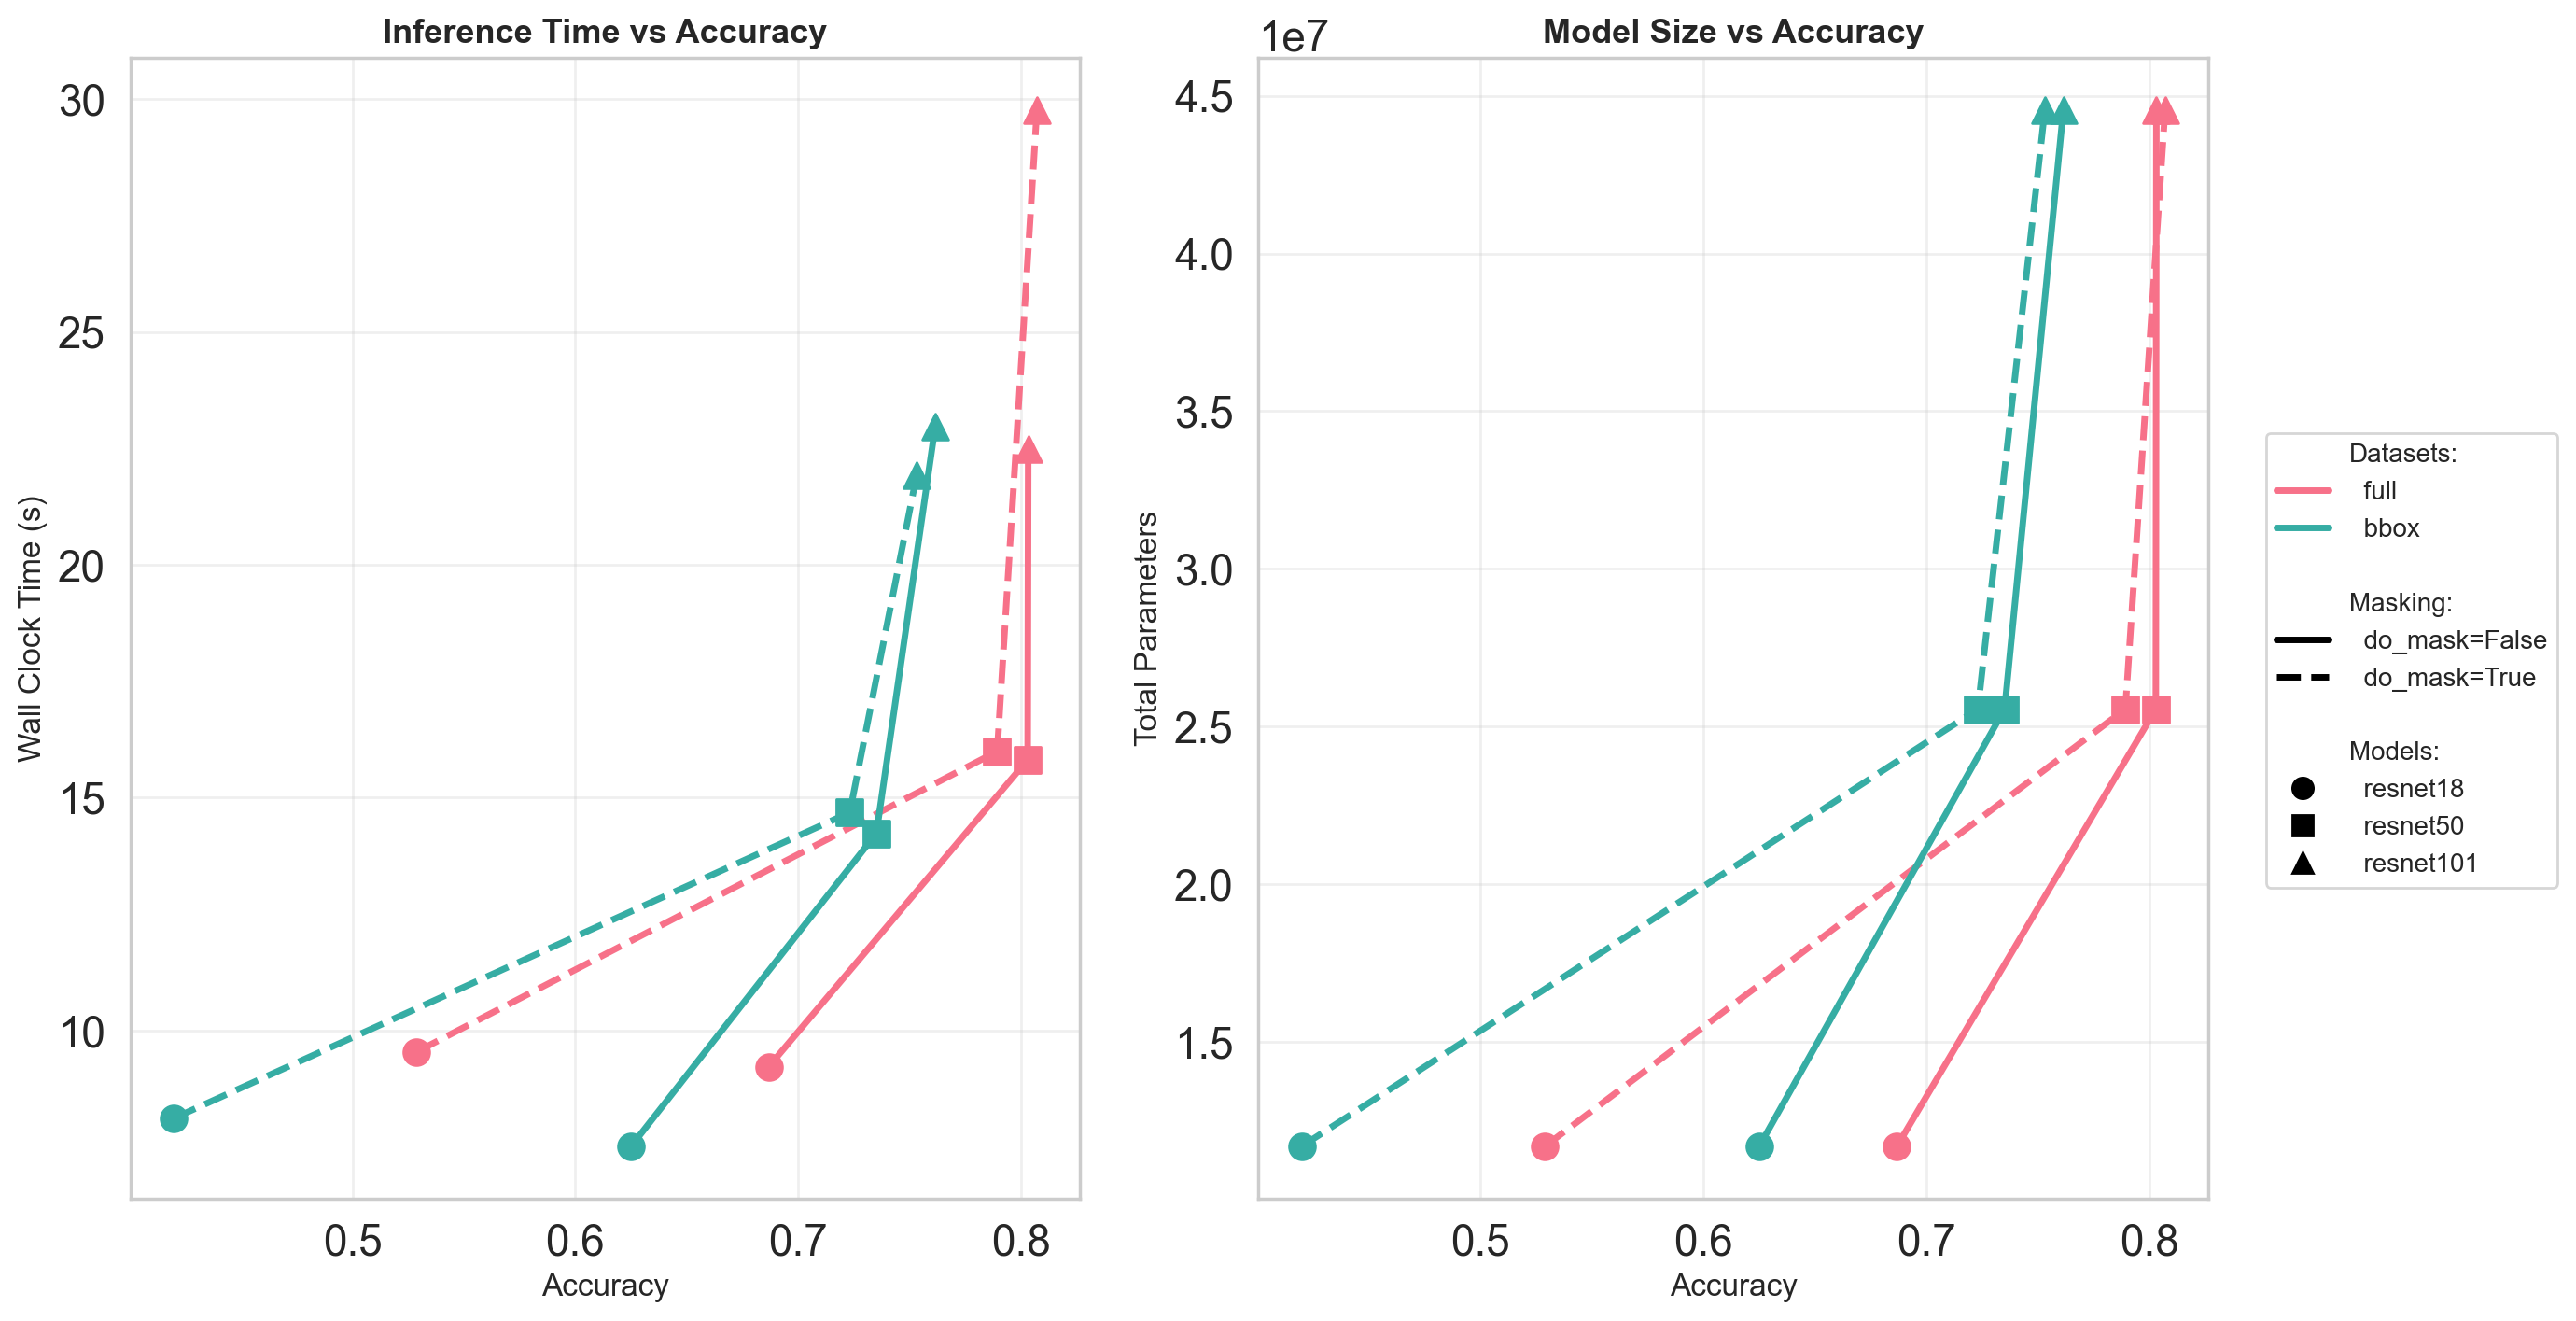

In [4]:
from matplotlib.lines import Line2D

# Sort results by accuracy within each group to connect points with lines
results_sorted = results.sort_values(['dataset', 'do_mask', 'accuracy'])

# Define line styles based on do_mask
linestyles = {True: '--', False: '-'}

# Define markers for different models
markers = {model_name: marker for model_name, marker in 
           zip(fovea.all_model_names, ['o', 's', '^', 'D', 'v', 'p', '*', 'H'][:len(fovea.all_model_names)])}

# Create figure with 2 subplots
fig, axes = fovea.plt.subplots(1, 2)

# Define color palette for datasets
palette = fovea.sns.color_palette("husl", len(fovea.all_datasets))
dataset_colors = {dataset: palette[i] for i, dataset in enumerate(fovea.all_datasets)}

# Plot 1: Wall clock time vs Accuracy
ax = axes[0]
for dataset in fovea.all_datasets:
    for do_mask in [False, True]:
        # Get all data for this dataset/do_mask combination, ordered by model_name order
        data_subset = results_sorted[
            (results_sorted['dataset'] == dataset) & 
            (results_sorted['do_mask'] == do_mask)
        ].copy()
        # Preserve the order of fovea.all_model_names
        data_subset['model_name'] = data_subset['model_name'].astype('category')
        data_subset['model_name'] = data_subset['model_name'].cat.set_categories(fovea.all_model_names)
        data_subset = data_subset.sort_values('model_name')
        
        if len(data_subset) > 0:
            # Plot all models connected by a single line
            ax.plot(data_subset['accuracy'], 
                    data_subset['wall_clock_time'],
                    linestyle=linestyles[do_mask],
                    color=dataset_colors[dataset],
                    linewidth=2.5,
                    label=f'{dataset} (mask={do_mask})')
            
            # Add markers for each model
            for model_name in fovea.all_model_names:
                model_data = data_subset[data_subset['model_name'] == model_name]
                if len(model_data) > 0:
                    ax.scatter(model_data['accuracy'], 
                              model_data['wall_clock_time'],
                              marker=markers[model_name],
                              color=dataset_colors[dataset],
                              s=100,
                              zorder=5)

ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Wall Clock Time (s)', fontsize=12)
ax.set_title('Inference Time vs Accuracy', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
# ax.legend(fontsize=10, loc='best')

# Plot 2: Total parameters vs Accuracy
ax = axes[1]
for dataset in fovea.all_datasets:
    for do_mask in [False, True]:
        # Get all data for this dataset/do_mask combination, sorted by model and accuracy
        data_subset = results_sorted[
            (results_sorted['dataset'] == dataset) & 
            (results_sorted['do_mask'] == do_mask)
        ].copy()
        # Preserve the order of fovea.all_model_names
        data_subset['model_name'] = data_subset['model_name'].astype('category')
        data_subset['model_name'] = data_subset['model_name'].cat.set_categories(fovea.all_model_names)
        data_subset = data_subset.sort_values('model_name')
        
        if len(data_subset) > 0:
            # Plot all models connected by a single line
            ax.plot(data_subset['accuracy'], 
                    data_subset['total_parameters'],
                    linestyle=linestyles[do_mask],
                    color=dataset_colors[dataset],
                    linewidth=2.5,
                    label=f'{dataset} (mask={do_mask})')
            
            # Add markers for each model
            for model_name in fovea.all_model_names:
                model_data = data_subset[data_subset['model_name'] == model_name]
                if len(model_data) > 0:
                    ax.scatter(model_data['accuracy'], 
                              model_data['total_parameters'],
                              marker=markers[model_name],
                              color=dataset_colors[dataset],
                              s=100,
                              zorder=5)

ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Total Parameters', fontsize=12)
ax.set_title('Model Size vs Accuracy', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
# ax.legend(fontsize=10, loc='best')

# Create custom legend
legend_elements = []

# Add dataset colors
legend_elements.append(Line2D([0], [0], color='none', label='Datasets:', lw=0))
for dataset in fovea.all_datasets:
    legend_elements.append(Line2D([0], [0], color=dataset_colors[dataset], lw=2.5, label=f'  {dataset}'))

legend_elements.append(Line2D([0], [0], color='none', label='', lw=0))  # Spacer

# Add line styles
legend_elements.append(Line2D([0], [0], color='none', label='Masking:', lw=0))
legend_elements.append(Line2D([0], [0], color='black', linestyle='-', lw=2.5, label='  do_mask=False'))
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', lw=2.5, label='  do_mask=True'))

legend_elements.append(Line2D([0], [0], color='none', label='', lw=0))  # Spacer

# Add models with markers
legend_elements.append(Line2D([0], [0], color='none', label='Models:', lw=0))
for model_name in fovea.all_model_names:
    legend_elements.append(Line2D([0], [0], marker=markers[model_name], color='black', 
                                      linestyle='none', markersize=8, label=f'  {model_name}'))

# Add legend to figure
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)

fovea.plt.tight_layout()
fovea.plt.subplots_adjust(right=1.)
fovea.savefig(fig, name='13_model_comparison', figures_folder=args.figures_folder, exts=['pdf'])    
fovea.plt.show()